<a href="https://colab.research.google.com/github/woohwan/huggingface-nlp-transformers-practice/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U accelerate
! pip install -U transformers

!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개의 데이터 셋: {all_datasets[:10]}")

<ipython-input-2-f74f3a81ab9c>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 90450개의 데이터셋이 있습니다.
처음 10개의 데이터 셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [10]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-12-30 12:58:02--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]   1.58M  --.-KB/s    in 0.06s   

2023-12-30 12:58:02 (27.0 MB/s) - ‘train.txt.1’ saved [1658616/1658616]



In [11]:
! head -n 1 train.txt

i didnt feel humiliated;sadness


In [12]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

In [13]:
emotions_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

### 2.1.2 데이터셋에서 데이터프레임으로

In [14]:
import pandas as pd

emotions.set_format("pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3  클래스 분포 살펴보기

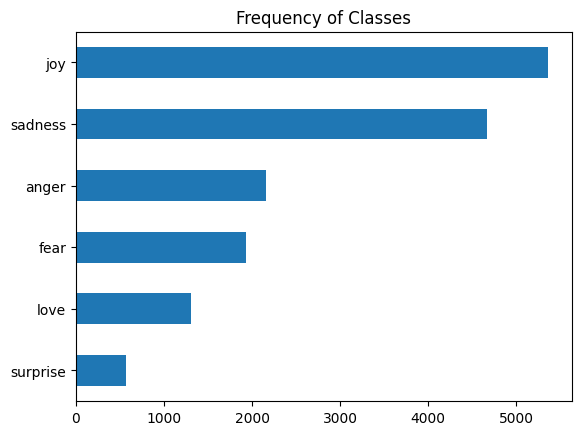

In [16]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show();

### 2.1.4. 트윗 길이 확인

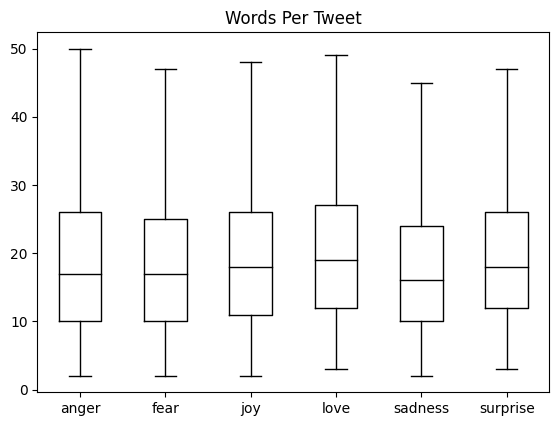

In [17]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [18]:
# dataset output format 초기화
emotions.reset_format()

## 2.2 텍스트에서 토큰으로

### 2.2.1 문자토큰화

In [19]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [20]:
# numericalization
token2idx = {ch:idx for idx, ch in enumerate(sorted(set(tokenized_text))) }
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [21]:
input_ids = [ token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [22]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [23]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스:  {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스:  5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### 2.2.2 단어 토큰화

In [24]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [25]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [26]:
# 특정 클래스를 수동으로 로드
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [27]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [28]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [29]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [30]:
tokenizer.vocab_size

30522

In [31]:
tokenizer.model_max_length

512

In [32]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 2.2.4 전체 데이테셋 토큰화하기

In [33]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [34]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [35]:
# batch_size=None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로, 입력텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [36]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 2.3 텍스트 분류 모델 훈련하기

In [37]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

#### 마지막 은닉 상태 추출하기

In [38]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [39]:
input_tokens = tokenizer(text)
input_tokens

{'input_ids': [101, 2023, 2003, 1037, 3231, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [40]:
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask'])


In [41]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [42]:
inputs = { k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [43]:
print(inputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}


In [44]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [45]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [46]:
print(tokenizer.model_input_names)

['input_ids', 'attention_mask']


In [47]:
def extract_hidden_states(batch):
  # 모델 입력을 GPU로 옮깁니다.
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # 마지막 은닉상태를 추출합니다.
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # [CLS] 토큰에 대한 벡터를 반환합니다.
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [48]:
# 이 모델은 텐서가 입력되기를 기대하므로, 다음처럼 input_Ids와 attentions_mask열을 'torch' 포맷으로 바꿉니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [49]:
# 은닉싱태 추출
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [50]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [51]:
# 특성 행렬 만들기
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [52]:
! pip uninstall umap  -y
! pip uninstall umap-learn -y
!pip install umap-learn

Found existing installation: umap-learn 0.5.5
Uninstalling umap-learn-0.5.5:
  Successfully uninstalled umap-learn-0.5.5
  Using cached umap_learn-0.5.5-py3-none-any.whl


In [53]:
# 훈련 세트 시각화하기
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.057578,6.809174,0
1,-3.283561,6.332839,0
2,5.244890,3.299755,3
3,-2.694917,4.396552,2
4,-3.604251,4.518087,3


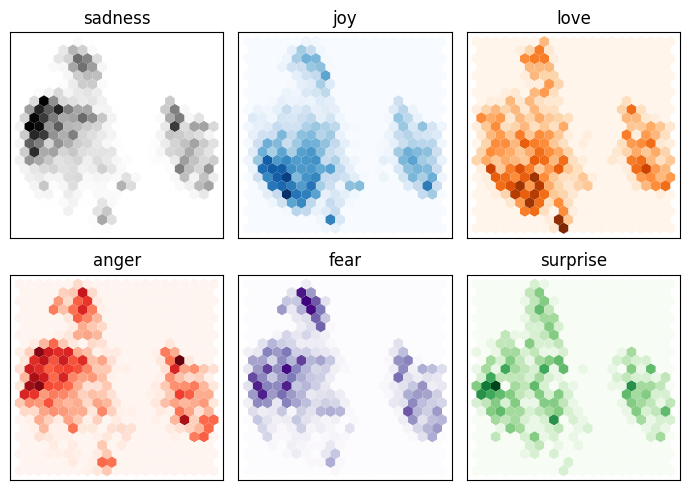

In [54]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show();


#### 간단한 분류모델 훈련하기

In [55]:
from sklearn.linear_model import LogisticRegression

# 수렴을 보장하기 위해 `max_iter`를 증가
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [56]:
# for Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

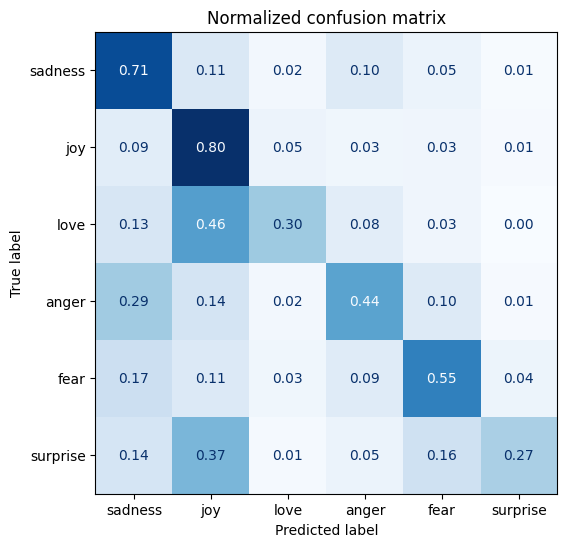

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
  cm = confusion_matrix(y_true, y_pred, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 2.3.2 트랜스포머 미세튜닝하기

#### 사전 훈련된 모델 로드하기

In [58]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 성공지표 정하기
훈련하는 동안 성능을 모니터링하기 위해 Trainer에 사용할 compute_metrics()함수를 정의

In [59]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [63]:
from huggingface_hub import notebook_login
notebook_login()

In [64]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [66]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.802800,0.287653,0.916000,0.915605
2,0.236200,0.205360,0.923000,0.923128


TrainOutput(global_step=500, training_loss=0.5195397033691406, metrics={'train_runtime': 237.5556, 'train_samples_per_second': 134.705, 'train_steps_per_second': 2.105, 'total_flos': 720342861696000.0, 'train_loss': 0.5195397033691406, 'epoch': 2.0})

In [67]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [68]:
preds_output.metrics

{'test_loss': 0.20536012947559357,
 'test_accuracy': 0.923,
 'test_f1': 0.9231277758666436,
 'test_runtime': 3.8535,
 'test_samples_per_second': 519.015,
 'test_steps_per_second': 8.304}

In [69]:
y_preds = np.argmax(preds_output.predictions, axis=1)

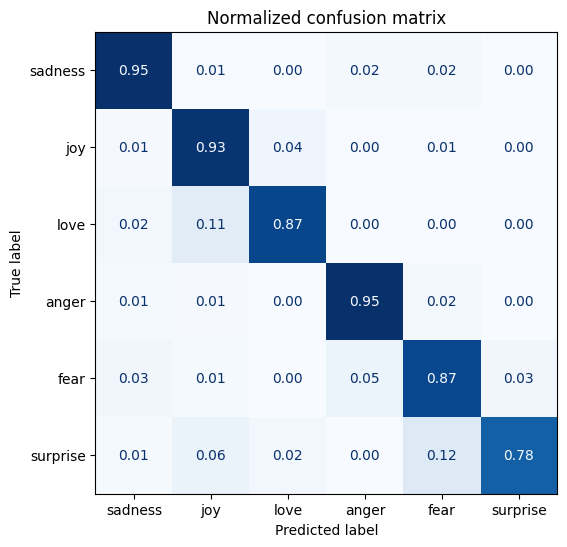

In [70]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류분석

In [77]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # 모든 입력 텐서를 모델과 같은 장치로 이동시킵니다.
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=1)
    loss = cross_entropy(output.logits, batch['label'].to(device), reduction="none")

  # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

다시 한번 map 메서드로 이 함수를 적용해 모든 샘플의 손실함수를 구합니다.

In [78]:
# 데이터셋을  다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [81]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

### 데이터셋의 특이사항

In [82]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.466292
1801,i feel that he was being overshadowed by the s...,love,sadness,5.402924
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.186278
1950,i as representative of everything thats wrong ...,surprise,sadness,5.172856
882,i feel badly about reneging on my commitment t...,love,sadness,5.102261
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.023111
1274,i am going to several holiday parties and i ca...,joy,sadness,4.858509
1111,im lazy my characters fall into categories of ...,joy,fear,4.582423
1509,i guess this is a memoir so it feels like that...,joy,fear,4.569279
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.484566


In [83]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1263,i feel this way about blake lively,joy,joy,0.015896
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.015928
1873,i feel practically virtuous this month i have ...,joy,joy,0.016140
456,im feeling rather festive here in south florida,joy,joy,0.016159
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.016397
578,i got to christmas feeling positive about the ...,joy,joy,0.016429
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,0.016439
1513,i have also been getting back into my gym rout...,joy,joy,0.016800
845,i already feel very glamorous have a great day...,joy,joy,0.016802
4,i can have for a treat or if i am feeling festive,joy,joy,0.016907


In [84]:
trainer.push_to_hub(commit_message="Training completed")

'https://huggingface.co/richard-park/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [85]:
from transformers import pipeline

model_id = "richard-park/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [86]:
custom_tweet = "I saw a movi today and it was really good"
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


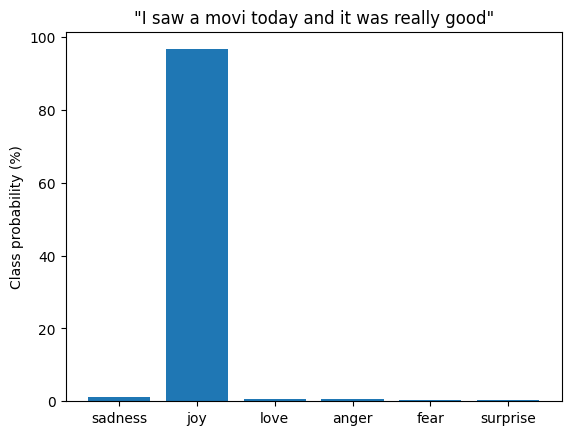

In [89]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show();